# MODEL AGNOSTIC TEST

This notebook allows to perform a model agnostic test, allowing two different framework to be compared. The only stric requiremnt is that the model produces, as output, a feature vector that is used to compare images.

In [1]:
from multiprocess import cpu_count
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import tensorflow as tf
import numpy as np
from sklearn.metrics import pairwise_distances
import seaborn
import pandas as pd

from tensorflow_similarity.samplers import MultiShotMemorySampler
from tensorflow_similarity.samplers import RandAugment
from tensorflow_similarity.architectures import EfficientNetSim
from tensorflow_similarity.losses import MultiSimilarityLoss
from tensorflow_similarity.visualization import confusion_matrix  # matching performance

import glob
import os
import sys
partial_path = os.getcwd().rsplit("/", 1)[0]
sys.path.insert(0, f"{partial_path}/src/")
from test_utils import test_agnostic_get_metrics, test_agnostic_show_pics
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2022-05-30 13:46:15.934055: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


### TEST SET DEFINITION

Test images have to be in the form "../{damage_id}_{photo_id}.*"

In [2]:
base_path = '../data/test_papers_2.1.0/'
print(len(os.listdir(base_path)))
all_files = glob.glob(os.path.join(base_path, '*'))

420


In [3]:
damages_ids=set([int(os.path.basename(i).split('_')[0]) for i in all_files])

### MODEL DEFINITION

In [4]:
IMG_SIZE = 256
embedding_size = 256
model = EfficientNetSim((IMG_SIZE, IMG_SIZE, 3), embedding_size=embedding_size, augmentation=None)
model.summary()

2022-05-30 13:46:31.276441: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-30 13:46:31.730946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-30 13:46:31.730981: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-30 13:46:31.734368: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-30 13:46:31.734440: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-05-30 13:46:31.735150: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2022-0

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
metric_embedding (MetricEmbe (None, 256)               327936    
Total params: 4,377,507
Trainable params: 327,936
Non-trainable params: 4,049,571
_________________________________________________________________


In [5]:
model

In [6]:
model = tf.keras.models.load_model("../models/LEGACY_best_tfsim_model/best_tf_sim_model")

Distance metric automatically set to cosine use the distance arg to override.


In [7]:
query=[]
gallery=[]

puntatore=0
for path in all_files:
    dam_id=int(os.path.basename(path).split('_')[0])
    if dam_id==puntatore:
        query.append(path)
        puntatore+=1
    elif dam_id==puntatore-1:
        gallery.append(path)
    else:
        puntatore+=1

In [8]:
query_idx=np.array([int(os.path.basename(path).split('_')[0]) for path in query])
gallery_idx=np.array([int(os.path.basename(path).split('_')[0]) for path in gallery])

In [9]:
@tf.function()
def process_val(p):
    img = tf.io.decode_image(p)
    img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE, IMG_SIZE)
    return img

def loader_val(x, y, sample_per_batch, is_warmup):

    imgs = []
    for p in x:
       imgs.append(tf.io.read_file(p))
    imgs = tf.stack(imgs)
    imgs = tf.map_fn(process_val, 
                     imgs, 
                     parallel_iterations=cpu_count(),
                     dtype='uint8')
    return imgs, y

In [10]:
query_loaded=loader_val(query, query_idx, None, None)[0]
gallery_loaded=loader_val(gallery, gallery_idx, None, None)[0]

2022-05-30 13:46:46.709044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-30 13:46:46.728236: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2445445000 Hz


In [11]:
query_feat=model.predict(query_loaded)
gallery_feat=model.predict(gallery_loaded)

2022-05-30 13:46:55.166879: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-05-30 13:46:55.613694: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2022-05-30 13:46:56.100632: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-30 13:46:56.100683: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-05-30 13:46:56.100973: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-30 13:46:56.101031: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-05-30 13:46:56.131755: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

In [ ]:
test_agnostic_show_pics(query,query_idx,  query_feat,
               gallery,gallery_idx,  gallery_feat)

  0%|          | 0/39 [00:00<?, ?it/s]

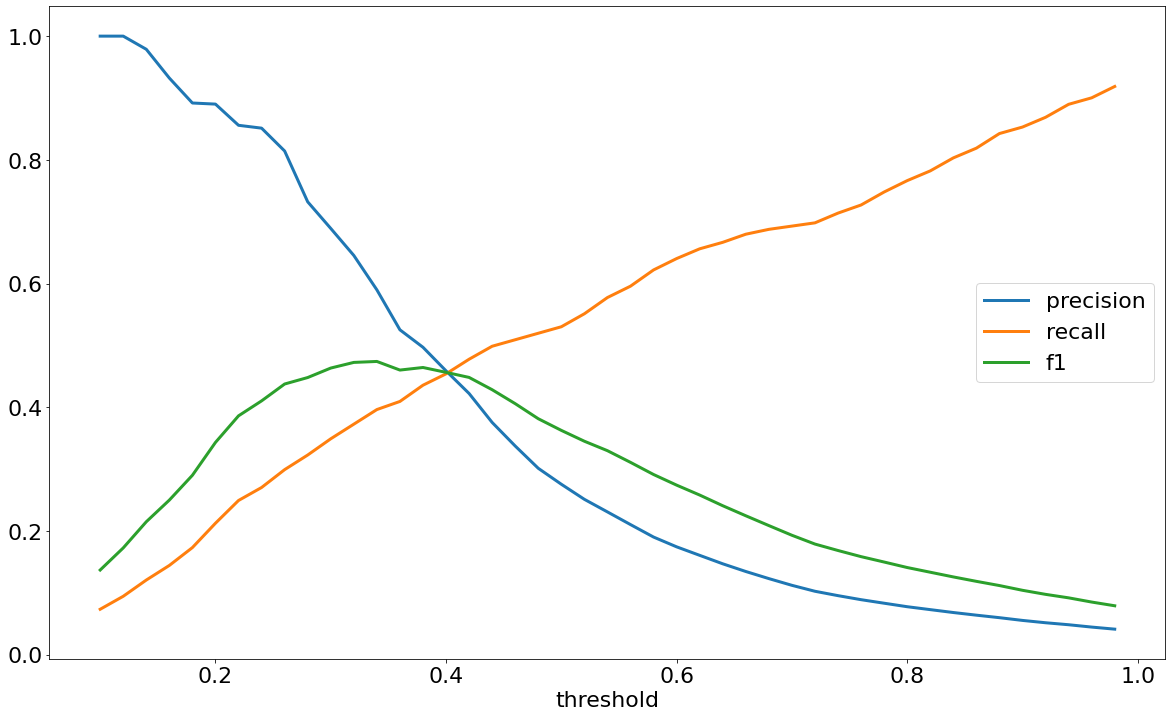

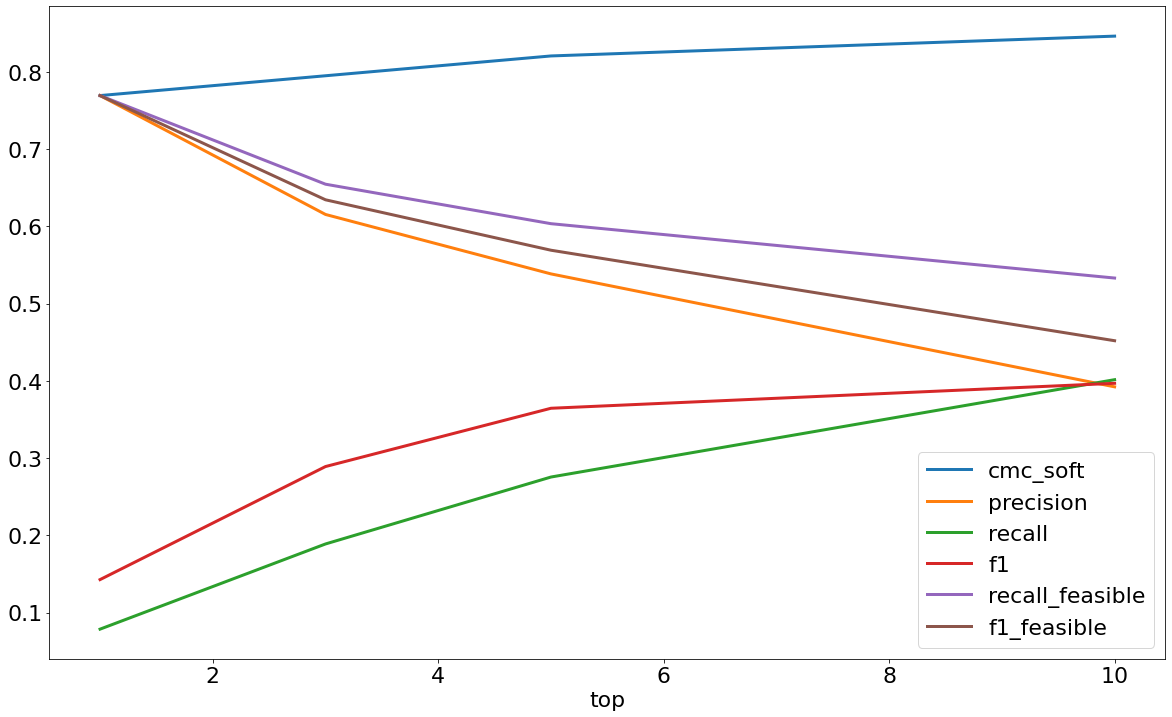

In [12]:
out=test_agnostic_get_metrics(query,query_idx,  query_feat,
               gallery,gallery_idx,  gallery_feat, 
               thresholds=np.arange(0.1,1,0.02), top=(10, 5, 3, 1))

In [13]:
out=test_agnostic_get_metrics(query,query_idx,  query_feat,
               gallery,gallery_idx,  gallery_feat, 
               thresholds=np.arange(0.15,0.3,0.01), top=(10, 5, 3, 1),
               display_metrics=True, plot_curves=False)

  0%|          | 0/39 [00:00<?, ?it/s]

,top,precision,recall,recall_feasible,f1,f1_feasible,cmc_soft
top_10,10,0.392308,0.401575,0.533101,0.396887,0.451994,0.846154
top_5,5,0.538462,0.275591,0.603448,0.364583,0.569106,0.820513
top_3,3,0.615385,0.188976,0.654545,0.289157,0.634361,0.794872
top_1,1,0.769231,0.078740,0.769231,0.142857,0.769231,0.769231


,threshold,precision,recall,f1
trash_0.15,0.15,0.960000,0.125984,0.222738
trash_0.16,0.16,0.932203,0.144357,0.250000
trash_0.17,0.17,0.925373,0.162730,0.276786
trash_0.18,0.18,0.891892,0.173228,0.290110
trash_0.19,0.19,0.886364,0.204724,0.332623
trash_0.2,0.20,0.890110,0.212598,0.343220
trash_0.21,0.21,0.866667,0.238845,0.374486
trash_0.22,0.22,0.855856,0.249344,0.386179
trash_0.23,0.23,0.852174,0.257218,0.395161
trash_0.24,0.24,0.851240,0.270341,0.410359


In [14]:
out=test_agnostic_get_metrics(query,query_idx,  query_feat,
               gallery,gallery_idx,  gallery_feat, 
               thresholds=np.arange(0.1,1,0.005), top=list(reversed(range(40)))[0:-1], 
               get_summary_metrics=True, plot_curves=False)

  0%|          | 0/39 [00:00<?, ?it/s]

mean average precision (mAP) is: 0.508
top-1 soft-positive Cumulative Matching Characteristics (CMC) is: 0.769
top-5 f1 feasible is : top_5    0.569
Name: f1_feasible, dtype: float64
top-10 f1 feasible is: top_10    0.452
Name: f1_feasible, dtype: float64
recall at 0.95 is:  0.121
recall at 0.9 is:  0.197
recall at 0.5 is:  0.436
